In [1]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from  Data_Selection import *
from  Data_Selection_for_BD import *
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.linalg import pinvh
from sklearn.linear_model import LinearRegression

In [2]:
def compute_phate_fisher_metric(phate_op, gene_expression, t_index=None):
    """
    Compute a Fisher-Information–style metric tensor at each PHATE embedding point,
    using PHATE's diffusion probabilities P^t and PHATE coords.

    Parameters
    ----------
    phate_op : phate.PHATE instance, already fit to your data.
        After `phate_op.fit(data)`, you can access:
          - phate_op.diff_op_  : the Markov matrix P
          - phate_op.diff_op_t : the matrix P^t
          - phate_op.embedding_: the (n_cells, 2) PHATE coords
    gene_expression : array (n_cells, n_genes)
        Original high-dimensional data.
    t_index : ignored (optional)
        PHATE uses its internal t; we take `diff_op_t` directly.

    Returns
    -------
    metrics : list of length n_cells
        Each entry is a (2×2) numpy array G(x_i).
    """
    # 1) Pull out diffusion probabilities P^t
    P_t = phate_op._calculate_potential(t="auto") # This is P^t
    assert gene_expression.shape[0] == P_t.shape[0], \
        f"Mismatch: gene_expression has {gene_expression.shape[0]} rows but PHATE was trained on {P_t.shape[0]}"
    X = phate_op.fit_transform(gene_expression)       # shape (n, 2)
    n, g = gene_expression.shape

    # Pre-allocate
    metrics = [np.zeros((2,2)) for _ in range(n)]

    # For each cell i:
    for i in range(n):
        w = P_t[i]                  # weights over all cells, sum ≈1
        # Local weighted mean of gene expr
        mu = w @ gene_expression    # shape (g,)

        # Local weighted covariance of gene expr
        G = (gene_expression - mu).T * w  # (g, n)
        Sigma = G @ (gene_expression - mu)  # (g, g)
        Sigma_inv = pinvh(Sigma + 1e-8*np.eye(g))

        # Approximate ∂μ/∂x1 and ∂μ/∂x2 by locally weighted linear regression
        # Fit 2 separate regressions: μ[:,j] ~ X[:,0] and μ[:,j] ~ X[:,1]
        # but we can vectorize: regress all genes at once
        # We'll build a design matrix of shape (n,2)
        reg = LinearRegression(fit_intercept=True)
        reg.fit(X, gene_expression, sample_weight=w)
        # reg.coef_ has shape (g, 2): partials ∂μ_j / ∂x_k
        J = reg.coef_.T            # shape (2, g)

        # Now the Fisher metric: G_ij = (∂μ/∂x_i)^T Σ⁻¹ (∂μ/∂x_j)
        metrics[i] = J @ Sigma_inv @ J.T  # shape (2,2)

    return metrics


In [3]:
# Generate toy data again
n = 1000
t = np.linspace(0, 1, n)
branch_1 = np.stack([t, t*0, t*0], axis=1)
branch_2 = np.stack([t, t, t*0], axis=1) + [1, 0, 0]
branch_3 = np.stack([t, -t, t*0], axis=1) + [1, 0, 0]
simple_3D = np.concatenate([branch_1, branch_2, branch_3], axis=0)
simple_3D += 0.05 * np.random.randn(*simple_3D.shape)

colors = np.linspace(0, 1, len(simple_3D))

fig = go.Figure(data=[go.Scatter3d(
    x=simple_3D[:, 0], y=simple_3D[:, 1], z=simple_3D[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors,
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.update_layout(
    title='Interactive 3D Toy Differentiation Data',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()


Calculating PHATE...
  Running PHATE on 3000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 10.89 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.97 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.86 seconds.
Calculated PHATE in 20.79 seconds.
Calculating PHATE...
  Running PHATE on 3000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t

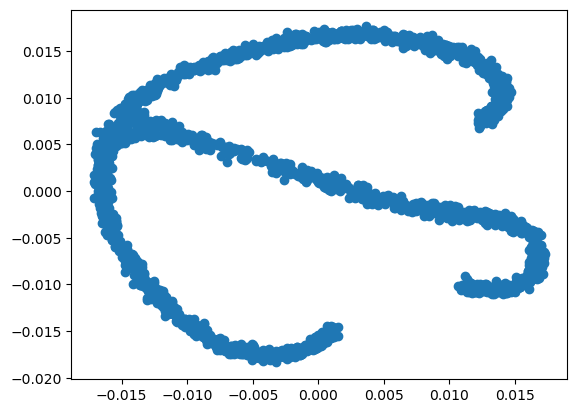

In [4]:
import phate

# 1) Fit PHATE to your matrix `data` (cells × genes):
phate_op = phate.PHATE(n_landmark=simple_3D.shape[0], n_components=2, knn=10, decay=20)
phate_coords = phate_op.fit_transform(simple_3D )    # data is (n_cells, n_genes)

# 2) Call our metric function:
metrics = compute_phate_fisher_metric(phate_op, simple_3D)
print(metrics)

plt.scatter(phate_coords[:, 0], phate_coords[:, 1])
plt.show()


Calculating PHATE...
  Running PHATE on 7000 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.25 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.30 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 112.76 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 17.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 68.40 seconds.
Calculated PHATE in 198.67 seconds.
Calculating PHATE...
  Running PHATE on 7000 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.23 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.27 seconds.
  Calculating optimal t...
    Automatically select

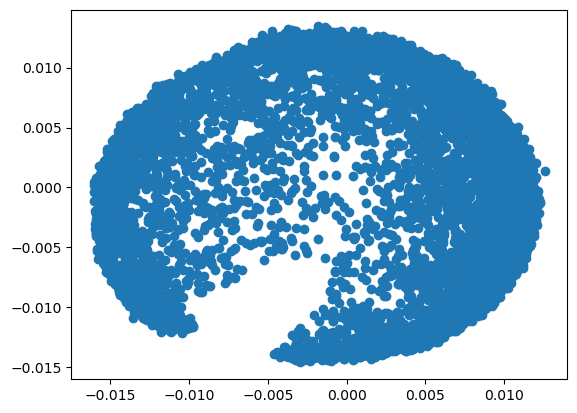

In [51]:
# Load CSV files into a DataFrame
file1 = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
df_facs_decision1 = pd.read_csv(file1)
selected_data_1, combined_equal_data_1  = data_selector_for_bd(1000, df_facs_decision1)


# 1) Fit PHATE to your matrix `data` (cells × genes):
phate_op_1 = phate.PHATE(n_landmark=selected_data_1.shape[0], n_components=2, knn=10, decay=20)
phate_coords_1 = phate_op_1.fit_transform(selected_data_1)    # data is (n_cells, n_genes)

# 2) Call our metric function:
metrics_1 = compute_phate_fisher_metric(phate_op_1, selected_data_1)
print(metrics_1)

plt.scatter(phate_coords_1[:, 0], phate_coords_1[:, 1])
plt.show()



In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fisher_quiver(phate_coords, metrics, step=5, scale=60):
    """
    Plot Fisher Information vectors over PHATE embedding using quiver arrows.

    Parameters
    ----------
    phate_coords : (n, 2) numpy array
        The PHATE 2D embedding of the data.
    metrics : list of (2x2) numpy arrays
        A Fisher metric tensor for each point.
    step : int
        Number of arrows to skip between each plotted arrow (for clarity).
    scale : float
        Length scaling factor for the arrows.
    """
    # Sample subset for clarity
    idx = np.arange(0, len(phate_coords), step)
    coords_sampled = phate_coords[idx]
    metrics_sampled = [metrics[i] for i in idx]

    # Extract principal eigenvector from each metric
    U = []  # x-component
    V = []  # y-component
    for G in metrics_sampled:
        vals, vecs = np.linalg.eigh(G)
        direction = vecs[:, 1]  # principal direction
        magnitude = np.sqrt(vals[1]) if vals[1] > 0 else 0
        U.append(direction[0] * magnitude)
        V.append(direction[1] * magnitude)

    U = np.array(U)
    V = np.array(V)

    # Plot
    plt.figure(figsize=(9, 9))
    plt.quiver(coords_sampled[:, 0], coords_sampled[:, 1],
               U, V, color='black', angles='xy', scale_units='xy', scale=scale)
    plt.scatter(phate_coords[:, 0], phate_coords[:, 1], s=2, alpha=0.3, color='steelblue')
    plt.title('Fisher Vector Field (Quiver Style)')
    plt.xlabel('PHATE1')
    plt.ylabel('PHATE2')
    plt.grid(True)
    plt.axis('equal')
    plt.show()



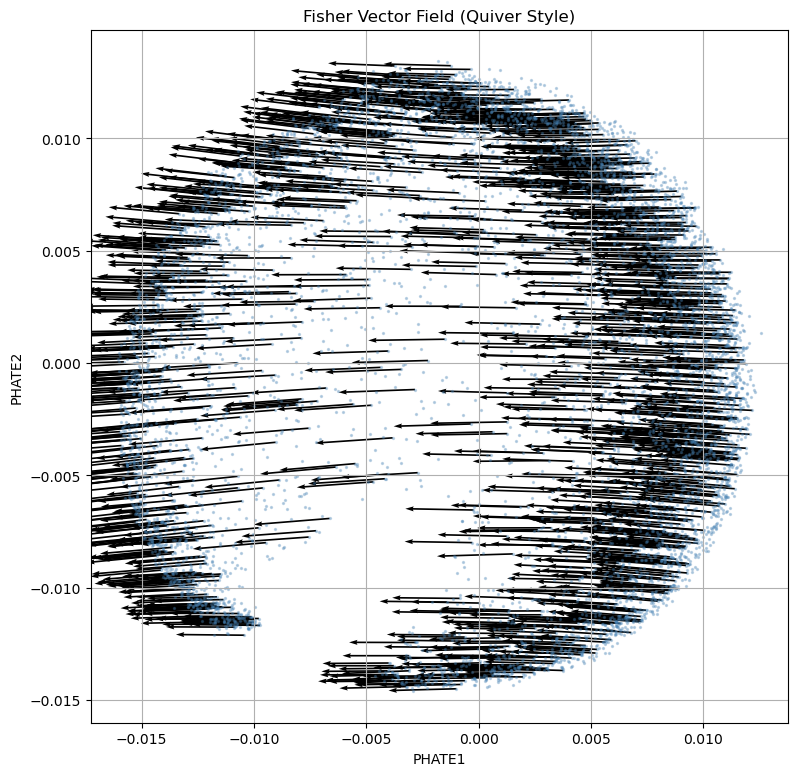

In [53]:
plot_fisher_quiver(phate_coords_1, metrics_1, scale=100)


# Visualization of Potential

Calculating PHATE...
  Running PHATE on 7000 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.49 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.06 seconds.
  Calculated landmark operator in 3.84 seconds.
  Calculating optimal t...
    Automatically selected t = 38
  Calculated optimal t in 3.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.94 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.31 seconds.
Calculated PHATE in 11.37 seconds.


ValueError: 'c' argument has 1991 elements, which is inconsistent with 'x' and 'y' with size 7000.

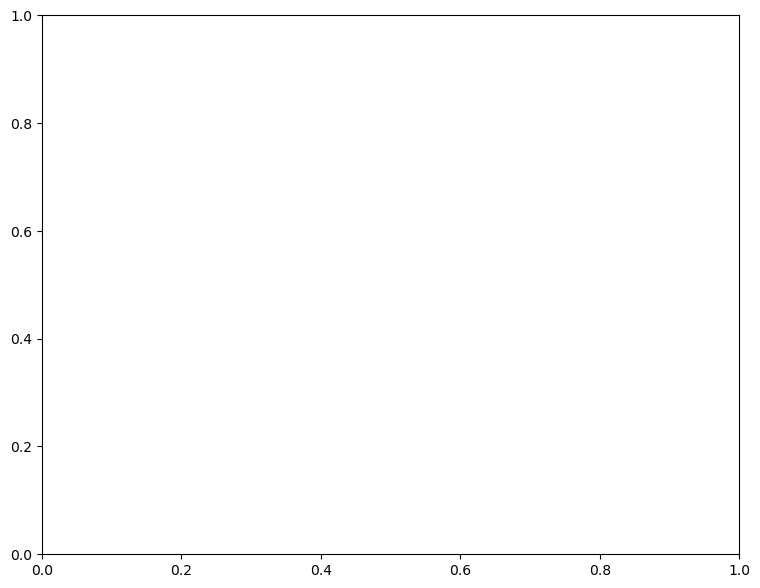

In [54]:
import phate
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Fit PHATE to your gene expression data
phate_op = phate.PHATE()
phate_coords = phate_op.fit_transform(selected_data_1)  # shape (n_cells, 2)

# STEP 2: Extract the diffusion potential matrix (P^t)
P_t = phate_op._calculate_potential(t='auto')  # shape (n_cells, n_cells)

# STEP 3: Compute the potential U(i) = -Σ_j P_ij * log(P_ij)
entropy = -np.sum(P_t * np.log(P_t + 1e-12), axis=1)  # shape (n_cells,)

# STEP 4: Plot PHATE embedding with potential overlaid
plt.figure(figsize=(9, 7))
plt.scatter(phate_coords[:, 0], phate_coords[:, 1], c=entropy, cmap='plasma', s=15)
plt.colorbar(label="PHATE Potential (Entropy)")
plt.title("PHATE Potential Landscape")
plt.xlabel("PHATE1")
plt.ylabel("PHATE2")
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import phate

# Simulate toy gene expression data for demonstration
np.random.seed(42)
n_cells = 300
gene_expression = np.random.rand(n_cells, 5)

# Fit PHATE
phate_op = phate.PHATE()
phate_coords = phate_op.fit_transform(gene_expression)

# Calculate diffusion potential (Von Neumann Entropy per cell)
P_t = phate_op._calculate_potential(t='auto')
entropy = -np.sum(P_t * np.log(P_t + 1e-12), axis=1)

# Interpolate entropy on a grid
x, y = phate_coords[:, 0], phate_coords[:, 1]
grid_x, grid_y = np.mgrid[min(x):max(x):200j, min(y):max(y):200j]
grid_entropy = griddata((x, y), entropy, (grid_x, grid_y), method='cubic')

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_entropy, cmap='plasma', edgecolor='none', alpha=0.9)
ax.set_title("PHATE Diffusion Potential Landscape")
ax.set_xlabel("PHATE1")
ax.set_ylabel("PHATE2")
ax.set_zlabel("Potential (Entropy)")

plt.tight_layout()
plt.show()
